exploration_13  
  pytorch dcgan tutorial

데이터 로드 및 전처리

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

#시드 고정
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 랜덤시드용 
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
!pip install torchsummary

In [3]:
#코랩 폴더
dataroot = "/content/"

#데이터 로더 스레드 개수
workers = 2

batch_size = 128

# transformer 때 resize 값
image_size = 32

# 컬러 채널
nc = 3

# generator 의 인풋 사이즈(랜덤값)
nz = 100

# generator 의 conv 채널 개수(feature maps)
ngf = 128

# descriminator conv 채널 개수(feature maps)
ndf = 128

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers #m(t) =b1*m(t-1) + (1-b1)*g(t-1)
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.  colab p100
ngpu = 1

Files already downloaded and verified


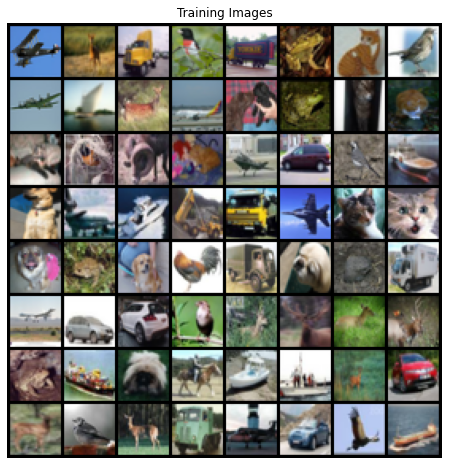

In [4]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ])
trainset = torchvision.datasets.CIFAR10(root='/content/', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


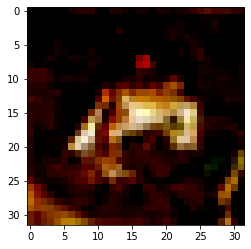

In [5]:
plt.imshow(trainset[0][0].permute(1, 2, 0))

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

모델생성

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 100, -> 128*4 channels , kerner size = 4x4 , stride 1, padding 0
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 4+2x3 = 10 = 8+ 2(pad)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 4+2x7 = 18 = 16+ 2(pad)
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 4+ 2*15 = 34 = 32+ 2(pad)
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [9]:
from torchsummary import summary

In [10]:
summary(netG,torch.Size([100, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           6,144
             Tanh-11            [-1, 3, 32, 32]               0
Total params: 3,448,576
Trainable params: 3,448,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        

        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
summary(netD,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
            Conv2d-3            [-1, 256, 8, 8]         524,288
       BatchNorm2d-4            [-1, 256, 8, 8]             512
         LeakyReLU-5            [-1, 256, 8, 8]               0
            Conv2d-6            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9           [-1, 1024, 2, 2]       8,388,608
      BatchNorm2d-10           [-1, 1024, 2, 2]           2,048
        LeakyReLU-11           [-1, 1024, 2, 2]               0
           Conv2d-12              [-1, 1, 1, 1]           4,096
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 11,023,872
Trainable para

hyperparameter 설정

In [24]:
# Initialize BCELoss function # 기준 loss function 선택
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=device) #64로 돌리기.

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D #beta2 = recommended value.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

train step 

In [ ]:
img_list = [] #슬라이드를 위한 리스트
G_losses = [] # plot 그리기 위한 리스트
D_losses = [] # plot 그리기 위한 리스트
iters = 0 # 시작 iter 0

In [15]:


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader # index 0부터 시작.
    for i, data in enumerate(dataloader, 0): 

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch # data[0] =torch.Tensor(이미지), data[1] 라벨.
        #converting a CPU Tensor with pinned memory to a CUDA Tensor
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D # .view(-1)->flatten
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad(): # no train
                fake = netG(fixed_noise).detach().cpu() #detach from graph
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/391]	Loss_D: 1.3994	Loss_G: 4.9305	D(x): 0.5045	D(G(z)): 0.4552 / 0.0090
[0/100][50/391]	Loss_D: 0.9495	Loss_G: 7.2392	D(x): 0.6017	D(G(z)): 0.0613 / 0.0022
[0/100][100/391]	Loss_D: 0.4640	Loss_G: 4.5974	D(x): 0.7424	D(G(z)): 0.0944 / 0.0157
[0/100][150/391]	Loss_D: 0.8978	Loss_G: 5.2576	D(x): 0.7718	D(G(z)): 0.3579 / 0.0126
[0/100][200/391]	Loss_D: 0.3585	Loss_G: 4.5824	D(x): 0.8334	D(G(z)): 0.1402 / 0.0140
[0/100][250/391]	Loss_D: 0.2099	Loss_G: 4.8435	D(x): 0.8869	D(G(z)): 0.0730 / 0.0117
[0/100][300/391]	Loss_D: 0.5585	Loss_G: 3.3987	D(x): 0.6643	D(G(z)): 0.0458 / 0.0441
[0/100][350/391]	Loss_D: 0.7447	Loss_G: 5.5538	D(x): 0.8308	D(G(z)): 0.3762 / 0.0064
[1/100][0/391]	Loss_D: 0.4664	Loss_G: 3.8386	D(x): 0.7063	D(G(z)): 0.0140 / 0.0384
[1/100][50/391]	Loss_D: 0.3688	Loss_G: 5.7586	D(x): 0.9785	D(G(z)): 0.2503 / 0.0060
[1/100][100/391]	Loss_D: 0.6035	Loss_G: 4.6234	D(x): 0.8325	D(G(z)): 0.2843 / 0.0258
[1/100][150/391]	Loss_D: 0.2498	Loss_G: 4.637

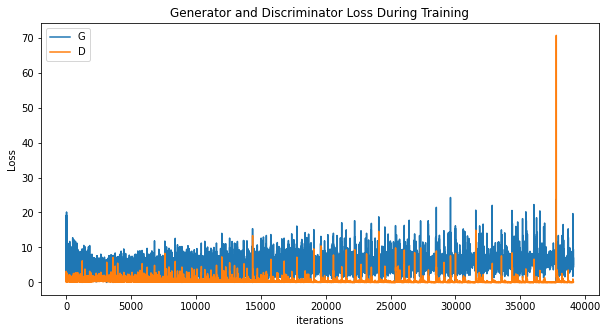

In [21]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

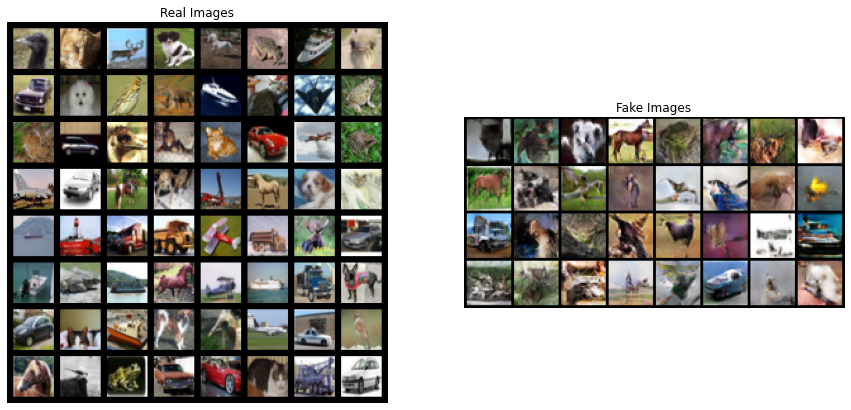

In [23]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

1. 파이토치의 tutorial 에 있는 dcgan 모델을 이용하여 생성.
  텐서플로우의 class 는 생각보다 자유롭게 다루기 힘듬. 
  클래스를 이용 및 라벨링을 작업하고자 할 때 불편.

2. 파이토치의 gcgan model tutorial 은 64x64 이미지를 이용(얼굴이미지)
여기서 레이어 개수 및 parameter 변경으로 32x32 이미지를 이용하도록 변경, 

기존 실패 결과.

![cifar_dcgan](https://user-images.githubusercontent.com/25836368/141986975-91e9555d-c809-46ab-96ab-cb5d576307b5.gif)

In [19]:
from PIL import Image

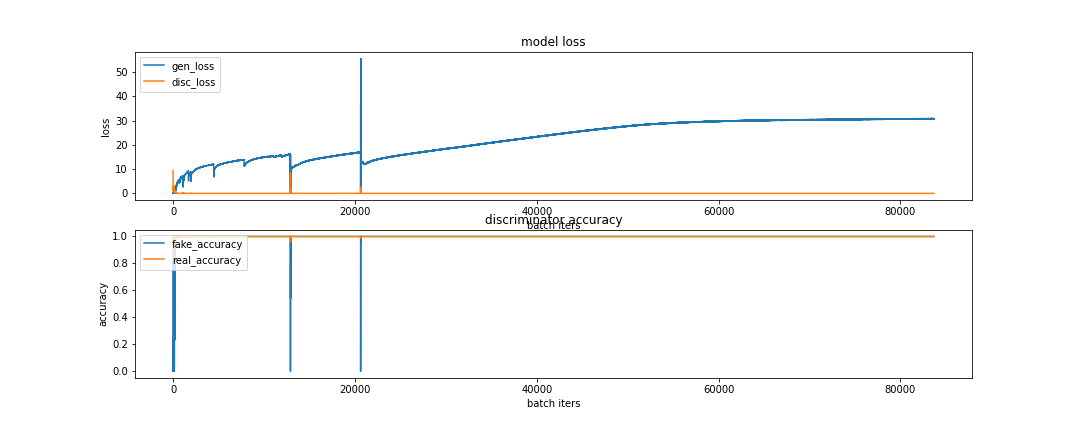

In [20]:
Image.open('/content/train_history_0426.png')

문제점- gan 생성속도가 느리고 수렴을 하지 않음.(라벨링을 안한 결과,tanh 가 아닌sigmoid 사용 결과)

gen 에서 sigmoid 쓰면 안됨.